In [1]:

import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [2]:

def clean_data(data):
    return np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)

In [3]:

geotiff_dir = '2022_geotiffs'

geotiff_files = sorted([os.path.join(geotiff_dir, f) for f in os.listdir(geotiff_dir) if f.endswith('.tif')])
print(f'Found {len(geotiff_files)} GeoTIFF files.')


data_arrays = []
count = 0
for geotiff_file in geotiff_files:
    with rasterio.open(geotiff_file) as src:
        data = src.read(1)
        if np.isnan(data).any(): 
            count += 1 
        data_arrays.append(clean_data(data))

data_array = np.array(data_arrays)
print(f'Data array shape: {data_array.shape}')
print(count)

Found 364 GeoTIFF files.
Data array shape: (364, 919, 1792)
0


In [4]:

from sklearn.preprocessing  import   MinMaxScaler
data_array_cnn = data_array[..., np.newaxis] 
print(f'Data shape for CNN: {data_array_cnn.shape}')

from scipy.ndimage import zoom


scale_factor = 0.1  

def resample_data(data, scale_factor):
    resampled_data = []
    for i in range(data.shape[0]):
        
        resampled_band = zoom(data[i], (scale_factor, scale_factor), order=1)  # order=1 means bilinear interpolation
        resampled_data.append(resampled_band)
    return np.array(resampled_data)


resampled_data = resample_data(data_array, scale_factor)
print(f'Resampled data shape: {resampled_data.shape}')  


resampled_data_cnn = resampled_data[..., np.newaxis]
print(f'Resampled data shape for CNN: {resampled_data_cnn.shape}')

print(f'Max value before normalization: {resampled_data_cnn.max()}')
print(f'Min value before normalization: {resampled_data_cnn.min()}')

Data shape for CNN: (364, 919, 1792, 1)
Resampled data shape: (364, 92, 179)
Resampled data shape for CNN: (364, 92, 179, 1)
Max value before normalization: 0.41603153944015503
Min value before normalization: 0.0


In [5]:
import numpy as np

resampled_data_cnn = np.array(resampled_data_cnn)

def prepare_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    X = np.array(X)
    y = np.array(y).reshape((-1, data.shape[1], data.shape[2], 1))
    return X, y

# Use the first 16 days to predict the 17th day
n_steps = 16
X, y = prepare_sequences(resampled_data_cnn, n_steps)


y = y.reshape((y.shape[0], y.shape[1], y.shape[2], 1))

print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')


Shape of X: (348, 16, 92, 179, 1)
Shape of y: (348, 92, 179, 1)


In [6]:

n_samples = X.shape[0]
train_size = int(n_samples * 0.7)

X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

print(f'Training set shape: X={X_train.shape}, y={y_train.shape}')
print(f'Validation set shape: X={X_val.shape}, y={y_val.shape}')

Training set shape: X=(243, 16, 92, 179, 1), y=(243, 92, 179, 1)
Validation set shape: X=(105, 16, 92, 179, 1), y=(105, 92, 179, 1)


In [7]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense, Dropout, Reshape, BatchNormalization, LeakyReLU, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

model = Sequential()


model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01)),
                          input_shape=(n_steps, resampled_data_cnn.shape[1], resampled_data_cnn.shape[2], 1)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(LeakyReLU(alpha=0.1)))
model.add(TimeDistributed(MaxPooling2D((2, 2), padding='same')))
model.add(TimeDistributed(Dropout(0.3)))

model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(LeakyReLU(alpha=0.1)))
model.add(TimeDistributed(MaxPooling2D((2, 2), padding='same')))
model.add(TimeDistributed(Dropout(0.3)))

model.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.01))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(LeakyReLU(alpha=0.1)))
model.add(TimeDistributed(MaxPooling2D((2, 2), padding='same')))
model.add(TimeDistributed(Dropout(0.3)))

model.add(TimeDistributed(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(0.01))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(LeakyReLU(alpha=0.1)))
model.add(TimeDistributed(MaxPooling2D((2, 2), padding='same')))
model.add(TimeDistributed(Dropout(0.3)))

model.add(TimeDistributed(Flatten()))


model.add(Bidirectional(LSTM(512, return_sequences=True, activation='tanh')))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(256, return_sequences=True, activation='tanh')))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128, return_sequences=True, activation='tanh')))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, return_sequences=False, activation='tanh')))
model.add(Dropout(0.5))


output_height, output_width = y_train.shape[1], y_train.shape[2]
flattened_output_size = output_height * output_width
model.add(Dense(flattened_output_size, activation='linear'))
model.add(Reshape((output_height, output_width, 1)))


optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

model.summary()

2024-07-14 04:54:38.600195: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 04:54:38.600240: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 04:54:38.601096: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-14 04:54:38.605973: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-14 04:54:39.228989: W tensorflow/compiler/tf2

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 16, 92, 179, 64)   640       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 16, 92, 179, 64)   256       
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 16, 92, 179, 64)   0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 16, 46, 90, 64)    0         
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 16, 46, 90, 64)    0

Epoch 1/200


2024-07-14 04:54:51.047958: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-07-14 04:54:51.596964: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-14 04:54:53.358914: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2a500a5ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-14 04:54:53.358960: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-07-14 04:54:53.366876: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1720932893.486274  278730 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


61/61 [==============================] - 25s 179ms/step - loss: 4.6801 - mae: 0.0924 - val_loss: 3.4892 - val_mae: 0.0266 - lr: 1.0000e-04
Epoch 2/200
61/61 [==============================] - 6s 98ms/step - loss: 2.7014 - mae: 0.0534 - val_loss: 2.0106 - val_mae: 0.0245 - lr: 1.0000e-04
Epoch 3/200
61/61 [==============================] - 6s 97ms/step - loss: 1.5528 - mae: 0.0436 - val_loss: 1.1577 - val_mae: 0.0517 - lr: 1.0000e-04
Epoch 4/200
61/61 [==============================] - 6s 98ms/step - loss: 0.8903 - mae: 0.0391 - val_loss: 0.6675 - val_mae: 0.0567 - lr: 1.0000e-04
Epoch 5/200
61/61 [==============================] - 6s 97ms/step - loss: 0.5117 - mae: 0.0354 - val_loss: 0.3869 - val_mae: 0.0522 - lr: 1.0000e-04
Epoch 6/200
61/61 [==============================] - 6s 97ms/step - loss: 0.2968 - mae: 0.0329 - val_loss: 0.2253 - val_mae: 0.0374 - lr: 1.0000e-04
Epoch 7/200
61/61 [==============================] - 6s 97ms/step - loss: 0.1745 - mae: 0.0313 - val_loss: 0.1350 - 

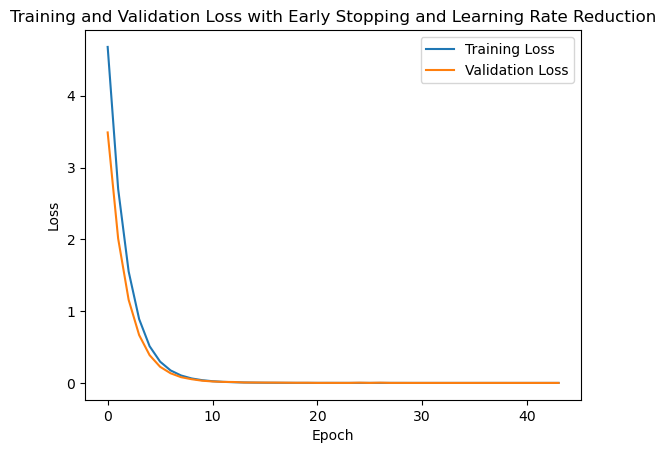

Training stopped after 44 epochs


In [8]:

history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=4,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss with Early Stopping and Learning Rate Reduction')
plt.show()


print(f"Training stopped after {len(history.history['loss'])} epochs")

Normalization bina ko code


In [9]:

# Function to predict the next 30 days
def predict_next_30_days(model, data, n_predictions):
    predictions = []
    current_seq = data[-16:]  # Start with the last available 16-day sequence
    for _ in range(n_predictions):
        pred = model.predict(current_seq.reshape((1, 16, data.shape[1], data.shape[2], 1)))
        
        predictions.append(pred[0])
        current_seq = np.append(current_seq[1:], pred, axis=0)  # Shift and include the new prediction
    return np.array(predictions)


n_predictions = 30
predicted_next_30_days = predict_next_30_days(model, resampled_data_cnn, n_predictions)

print(f'Predicted shape for the next 30 days: {predicted_next_30_days.shape}')

1/1 [==============================] - 0s 18ms/step
Predicted shape for the next 30 days: (30, 92, 179, 1)


In [9]:
import numpy as np

# Function to predict the next 30 days and inverse transform the predictions
def predict_next_30_days(model, data, scaler, n_predictions):
    predictions = []
    current_seq = data[-16:]  # Start with the last available 16-day sequence
    for _ in range(n_predictions):
        pred = model.predict(current_seq.reshape((1, 16, data.shape[1], data.shape[2], 1)))
        pred_inverse = scaler.inverse_transform(pred.reshape(-1, data.shape[1]*data.shape[2])).reshape(pred.shape)  # Inverse transform
        predictions.append(pred_inverse[0])
        current_seq = np.append(current_seq[1:], pred, axis=0)  # Shift and include the new prediction
    return np.array(predictions)

# Predict the next 30 days
n_predictions = 30
predicted_next_30_days = predict_next_30_days(model, resampled_data_cnn, scaler, n_predictions)

print(f'Predicted shape for the next 30 days: {predicted_next_30_days.shape}')


1/1 [==============================] - 0s 16ms/step
Predicted shape for the next 30 days: (30, 92, 181, 1)


Shape of resampled_data_cnn: (364, 92, 179, 1)
Shape of predicted_next_30_days: (30, 92, 179, 1)


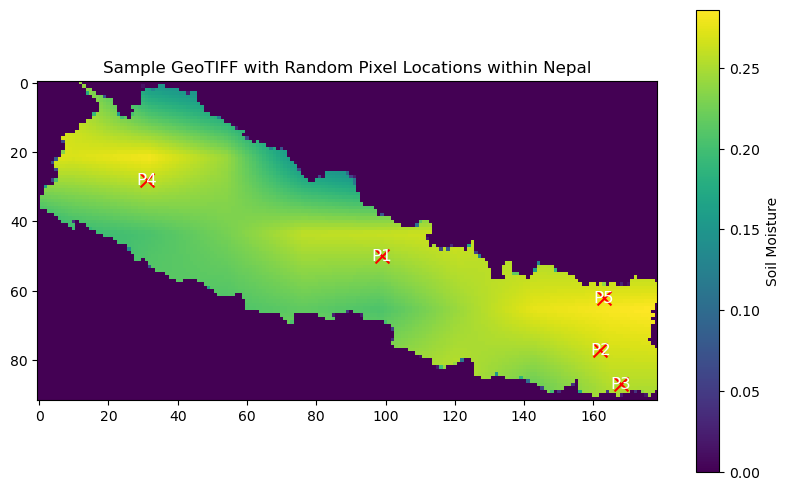

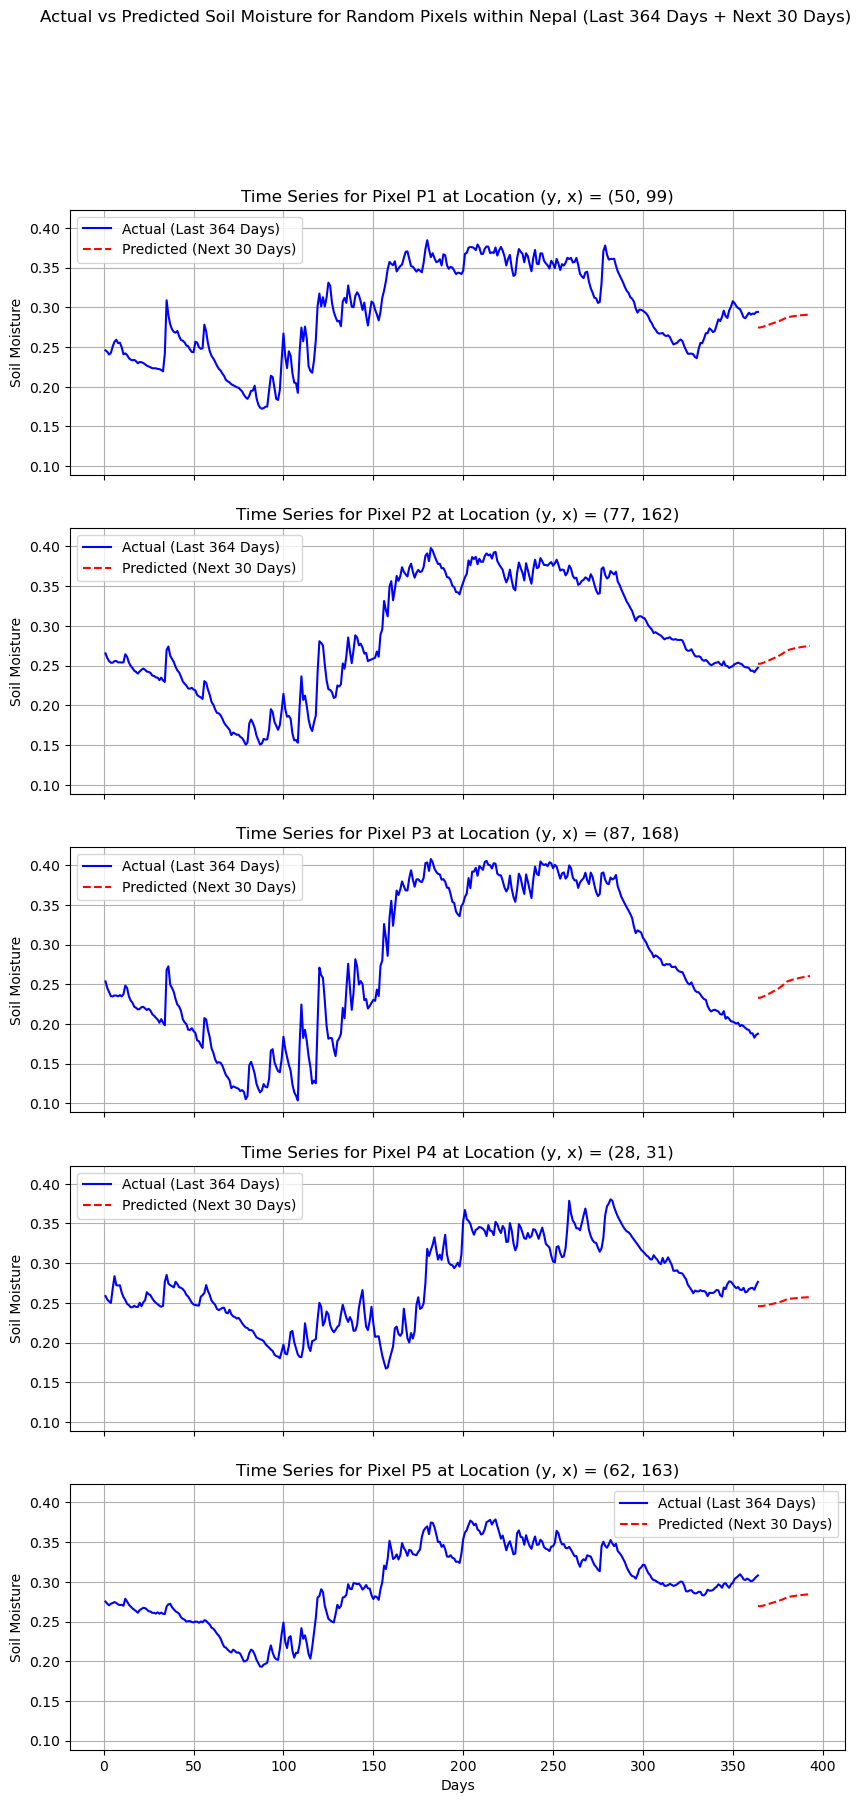

Pixel P1 at (y, x) = (50, 99):
Actual last 364 days
Pixel P2 at (y, x) = (77, 162):
Actual last 364 days
Pixel P3 at (y, x) = (87, 168):
Actual last 364 days
Pixel P4 at (y, x) = (28, 31):
Actual last 364 days
Pixel P5 at (y, x) = (62, 163):
Actual last 364 days


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import random


print("Shape of resampled_data_cnn:", resampled_data_cnn.shape)
print("Shape of predicted_next_30_days:", predicted_next_30_days.shape)


sample_band_index = 0
sample_data = resampled_data_cnn[sample_band_index, :, :, 0]


valid_mask = sample_data > 0
valid_pixels = np.argwhere(valid_mask)

# Select 5 random valid pixel locations
random_pixel_indices = random.sample(range(valid_pixels.shape[0]), 5)
random_pixels = valid_pixels[random_pixel_indices]

# Display the GeoTIFF image and plot random pixels
plt.figure(figsize=(10, 6))
plt.imshow(sample_data, cmap='viridis')
plt.colorbar(label='Soil Moisture')
plt.title('Sample GeoTIFF with Random Pixel Locations within Nepal')

# Plot the random pixels
for idx, (y, x) in enumerate(random_pixels):
    plt.scatter(x, y, c='red', s=100, marker='x')
    plt.text(x, y, f'P{idx+1}', color='white', fontsize=12, ha='center', va='center')

plt.show()

# Extract and plot time series for each random pixel
fig, axs = plt.subplots(5, 1, figsize=(10, 20), sharex=True, sharey=True)

for idx, (y, x) in enumerate(random_pixels):
    actual_last_364_days = resampled_data_cnn[-364:, y, x, 0] 


    predicted_next_30_days_flat = predicted_next_30_days[:, y, x, 0] 

    combined_days = np.arange(1, 395)  # 364 actual + 30 predicted
    combined_data = np.concatenate((actual_last_364_days, predicted_next_30_days_flat), axis=0)

   
    axs[idx].plot(range(1, 365), actual_last_364_days, label='Actual (Last 364 Days)', color='blue')
    axs[idx].plot(range(364, 394), predicted_next_30_days_flat, label='Predicted (Next 30 Days)', linestyle='--', color='red') 
    axs[idx].set_title(f'Time Series for Pixel P{idx+1} at Location (y, x) = ({y}, {x})')
    axs[idx].set_ylabel('Soil Moisture')
    axs[idx].legend()
    axs[idx].grid(True)

axs[-1].set_xlabel('Days')
plt.suptitle('Actual vs Predicted Soil Moisture for Random Pixels within Nepal (Last 364 Days + Next 30 Days)')
plt.show()


for idx, (y, x) in enumerate(random_pixels):
    print(f"Pixel P{idx+1} at (y, x) = ({y}, {x}):")
    print("Actual last 364 days")



In [11]:
import numpy as np

def predict_all_days(model, data, sequence_length=30):
    predictions = []

 
    for i in range(len(data) - sequence_length):
        current_seq = data[i:i + sequence_length]  

       
        current_seq_reshaped = current_seq.reshape((1, sequence_length, data.shape[1], data.shape[2], 1))

  

        pred = model.predict(current_seq_reshaped)

      

        predictions.append(pred[0])

    return np.array(predictions)


sequence_length = 16  


predicted_data = predict_all_days(model, resampled_data_cnn, sequence_length)


print(f'Predicted shape for the dataset: {predicted_data.shape}')
print(f'Sample predicted data: {predicted_data[0]}')


1/1 [==============================] - 0s 17ms/step
Predicted shape for the dataset: (348, 92, 179, 1)
Sample predicted data: [[[ 1.5915488e-04]
  [ 9.5196324e-04]
  [-1.2828509e-04]
  ...
  [-4.6728109e-04]
  [-6.1207917e-05]
  [-1.7429120e-04]]

 [[ 7.3248474e-04]
  [ 9.9713448e-04]
  [-1.5684869e-05]
  ...
  [-1.2114495e-03]
  [ 6.5676286e-04]
  [ 4.7382666e-05]]

 [[-1.9134032e-03]
  [-3.9571174e-04]
  [-1.2912182e-04]
  ...
  [-6.5491383e-04]
  [-1.4570687e-04]
  [-4.2394805e-04]]

 ...

 [[-5.7161594e-04]
  [ 3.1812384e-04]
  [ 4.9294118e-05]
  ...
  [ 2.6068586e-01]
  [ 2.6361752e-01]
  [-1.3646448e-03]]

 [[-6.5966917e-04]
  [ 1.6323302e-04]
  [-1.5852321e-04]
  ...
  [ 2.5553206e-01]
  [-1.8708839e-04]
  [-7.7087182e-04]]

 [[ 8.1798201e-04]
  [ 3.2643933e-05]
  [ 5.7944783e-04]
  ...
  [ 4.0142995e-04]
  [-5.4313883e-04]
  [-3.3232581e-04]]]


In [11]:
import numpy as np

def predict_all_days(model, data, scaler, sequence_length=30):
    predictions = []

  
    for i in range(len(data) - sequence_length):
        current_seq = data[i:i + sequence_length] 

        current_seq_reshaped = current_seq.reshape((1, sequence_length, data.shape[1], data.shape[2], 1))

  

        pred = model.predict(current_seq_reshaped)

      

        pred_reshaped = pred.reshape(-1, 1)

        pred_inverse = scaler.inverse_transform(pred_reshaped)

        pred_inverse = pred_inverse.reshape(pred.shape)
        predictions.append(pred_inverse[0])

    return np.array(predictions)

predicted_data = predict_all_days(model, resampled_data_cnn, scaler)

print(f'Predicted shape for the dataset: {predicted_data.shape}')
print(f'Sample predicted data: {predicted_data[0]}')

1/1 [==============================] - 0s 16ms/step
Predicted shape for the dataset: (329, 92, 181, 1)
Sample predicted data: [[[ 3.4906319e-05]
  [-6.5243351e-03]
  [-3.7874520e-04]
  ...
  [-6.4072181e-03]
  [-3.3418210e-03]
  [ 4.7021508e-03]]

 [[ 2.6410634e-03]
  [ 4.0648934e-03]
  [-2.0301663e-03]
  ...
  [-8.3415321e-04]
  [-1.7624856e-03]
  [-2.3686199e-03]]

 [[ 9.7756926e-04]
  [-4.1444330e-03]
  [ 3.2084049e-03]
  ...
  [ 3.2553498e-03]
  [-2.9835126e-03]
  [ 2.0351373e-03]]

 ...

 [[ 1.1230931e-03]
  [-2.5820655e-03]
  [-3.0997018e-03]
  ...
  [-5.5140806e-03]
  [-6.7290640e-03]
  [ 1.1143895e-02]]

 [[-5.7600378e-03]
  [ 2.3487823e-03]
  [ 1.5104305e-03]
  ...
  [ 8.5528446e-03]
  [ 6.0940781e-03]
  [ 2.9428242e-04]]

 [[-2.2766632e-03]
  [ 1.0736552e-03]
  [ 9.2768425e-04]
  ...
  [-3.1834361e-03]
  [-2.6265553e-03]
  [-7.0170144e-04]]]


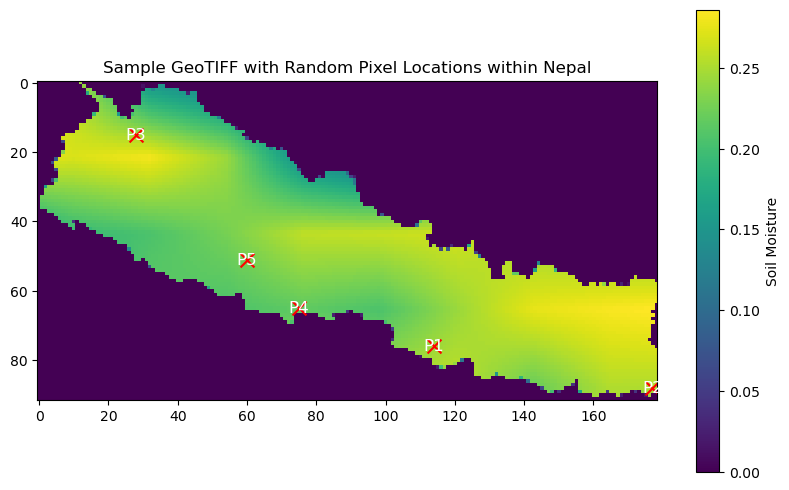

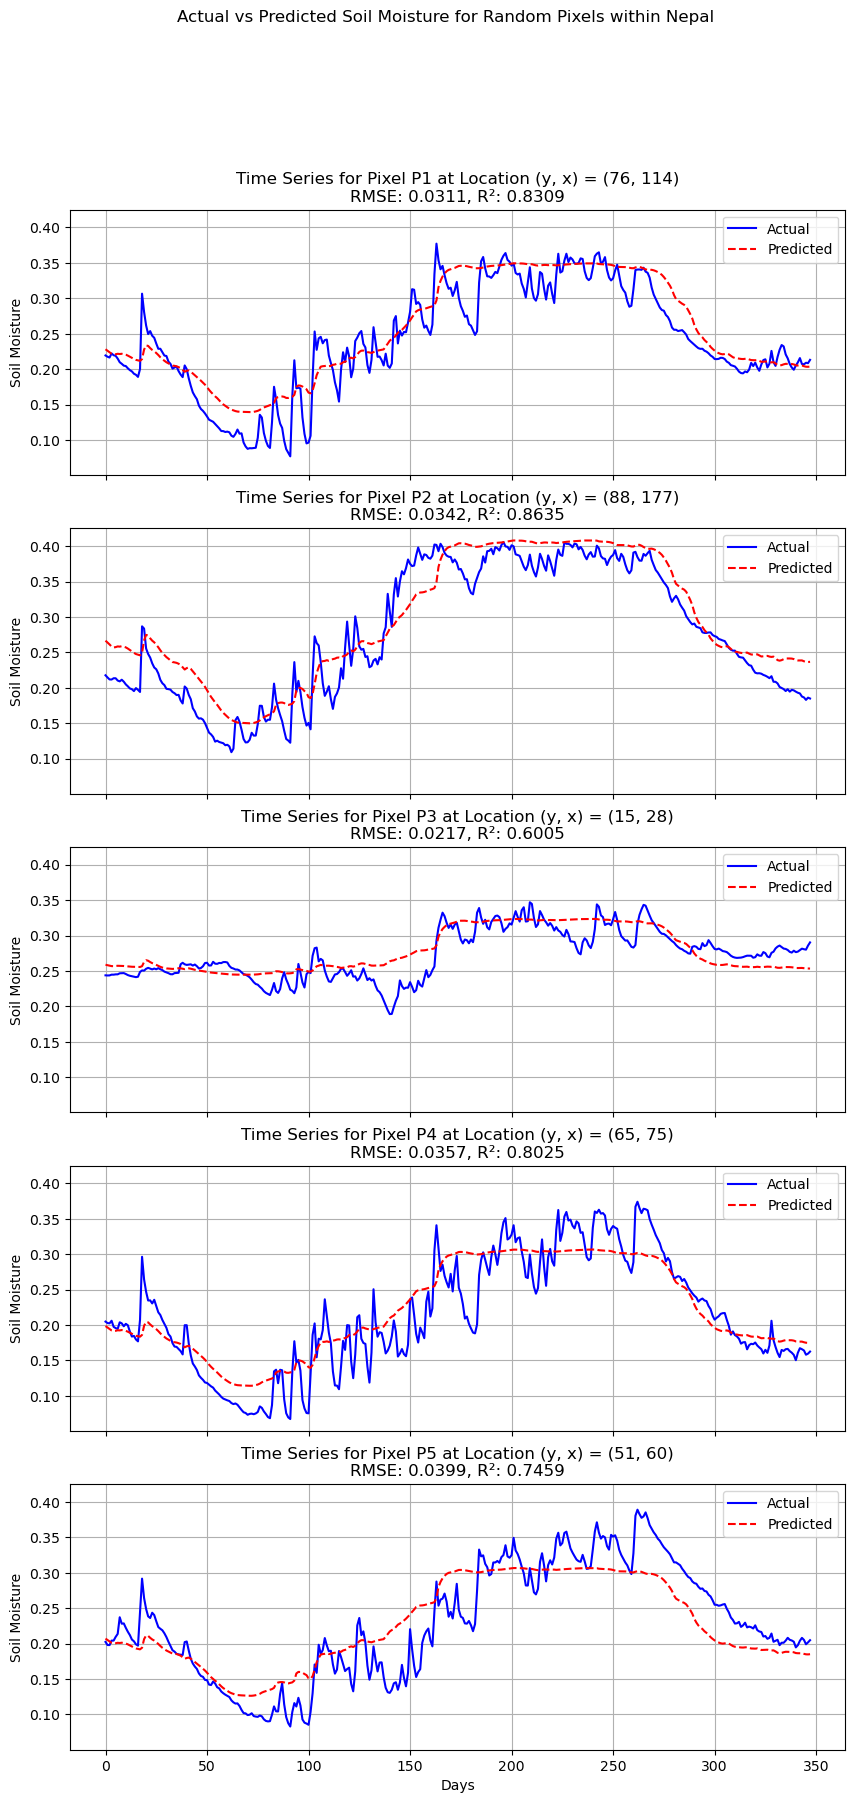

Pixel P1 at (y, x) = (76, 114):
Actual data:
[0.24408042 0.24201205 0.23444109 0.23919232 0.24957746 0.27062768
 0.27757812 0.26693928 0.26036805 0.24869369 0.23828982 0.25127488
 0.24486388 0.2330785  0.22676471 0.22286491 0.21931382 0.21753804
 0.21641508 0.22218168 0.21964389 0.21881442 0.21489404 0.20978689
 0.20755644 0.2049824  0.2043511  0.20118268 0.1986305  0.1968165
 0.19354215 0.19203569 0.1890825  0.20015682 0.30654937 0.28067783
 0.26166484 0.24954215 0.25373742 0.24716482 0.24429211 0.23616628
 0.22876126 0.22878934 0.22411656 0.21915565 0.21859486 0.21063681
 0.2074473  0.20072852 0.20237893 0.20373134 0.19721481 0.19238226
 0.18875894 0.20523085 0.19996938 0.18705541 0.17638081 0.16722701
 0.16202998 0.15757811 0.14856748 0.14377841 0.14110006 0.1374799
 0.13321629 0.12865533 0.12727314 0.1257246  0.12267975 0.11966027
 0.11640075 0.1127005  0.11252857 0.11130834 0.11180411 0.11086459
 0.106112   0.1044932  0.10858171 0.11476392 0.10894433 0.10940542
 0.09644957 0.09088

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_squared_error, r2_score


def plot_all_data_predictions(random_pixels, actual_data, predicted_data, sequence_length=16):
    fig, axs = plt.subplots(5, 1, figsize=(10, 20), sharex=True, sharey=True)

    for idx, (y, x) in enumerate(random_pixels):
        actual_vals = actual_data[sequence_length:, y, x, 0]  
        predicted_vals = predicted_data[:, y, x, 0]

        min_length = min(len(actual_vals), len(predicted_vals))
        actual_vals = actual_vals[:min_length]
        predicted_vals = predicted_vals[:min_length]

        combined_days = np.arange(len(actual_vals))

        # Calculate RMSE and R²
        rmse = np.sqrt(mean_squared_error(actual_vals, predicted_vals))
        r2 = r2_score(actual_vals, predicted_vals)

        # Plot actual vs predicted values
        axs[idx].plot(combined_days, actual_vals, label='Actual', color='blue')
        axs[idx].plot(combined_days, predicted_vals, label='Predicted', linestyle='--', color='red')
        axs[idx].set_title(f'Time Series for Pixel P{idx+1} at Location (y, x) = ({y}, {x})\nRMSE: {rmse:.4f}, R²: {r2:.4f}')
        axs[idx].set_ylabel('Soil Moisture')
        axs[idx].legend()
        axs[idx].grid(True)

    axs[-1].set_xlabel('Days')
    plt.suptitle('Actual vs Predicted Soil Moisture for Random Pixels within Nepal')
    plt.show()

# Display the GeoTIFF image with random pixel locations
sample_band_index = 0
sample_data = resampled_data_cnn[sample_band_index, :, :, 0]

# Create a mask for valid (non-background) pixels
valid_mask = sample_data > 0
valid_pixels = np.argwhere(valid_mask)

# Select 5 random valid pixel locations
random_pixel_indices = random.sample(range(valid_pixels.shape[0]), 5)
random_pixels = valid_pixels[random_pixel_indices]

# Display the GeoTIFF image and plot random pixels
plt.figure(figsize=(10, 6))
plt.imshow(sample_data, cmap='viridis')
plt.colorbar(label='Soil Moisture')
plt.title('Sample GeoTIFF with Random Pixel Locations within Nepal')

# Plot the random pixels
for idx, (y, x) in enumerate(random_pixels):
    plt.scatter(x, y, c='red', s=100, marker='x')
    plt.text(x, y, f'P{idx+1}', color='white', fontsize=12, ha='center', va='center')

plt.show()

# Plot predictions for the entire dataset for random pixels
plot_all_data_predictions(random_pixels, resampled_data_cnn, predicted_data)

# Optional: Print time series values for debugging
for idx, (y, x) in enumerate(random_pixels):
    print(f"Pixel P{idx+1} at (y, x) = ({y}, {x}):")
    print("Actual data:")
    print(resampled_data_cnn[:, y, x, 0])
    print("Predicted data:")
    print(predicted_data[:, y, x, 0])